# PwBandsWorkChain

In this notebook we compute the DFT bands on the same k-points used for the Wannier90 interpolated DFT bands of example `1_Band_interpolation_W90_DFT`. 

In [34]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='b35700dae723411ea16ebc82d58f16bc' name='mb'>

In [35]:
from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain

from aiida_wannier90_workflows.utils.workflows.builder.serializer import print_builder 
from aiida_wannier90_workflows.utils.workflows.builder.setter import set_parallelization, set_num_bands
from aiida_wannier90_workflows.utils.workflows.builder.submit import submit_and_add_group 
from aiida_wannier90_workflows.utils.workflows.builder.generator.post import (
    get_pwbands_builder_from_wannier,
    
)
from aiida_wannier90_workflows.workflows import Wannier90BandsWorkChain

In [ ]:
# Loading the wannier90 workchain performed before, to be used here.
w90_wkchain = orm.load_node(16085)

In [37]:
builder = get_pwbands_builder_from_wannier(w90_wkchain)

parallelization = {
    "npool": 8,
}
set_parallelization(builder, parallelization, process_class=PwBaseWorkChain)

builder.pw.metadata = {'options': {'max_wallclock_seconds': 43200,
                                   'queue_name':'s3par',
                                 'resources': {'num_machines': 1,
                                               'num_mpiprocs_per_machine':16,
                                               },
                                 'withmpi': True}}

print_builder(builder)


{'kpoints': 'GAMMA-M-K-GAMMA-A-L-H-A-L-M-H-K<None>',
 'kpoints_distance': 0.2,
 'kpoints_force_parity': False,
 'max_iterations': 5,
 'pw': {'code': 'pw-6.8-p2w_ham@hydralogin<2939>',
        'metadata': {'options': {'max_wallclock_seconds': 43200,
                                 'queue_name': 's3par',
                                 'resources': {'num_machines': 1,
                                               'num_mpiprocs_per_machine': 16},
                                 'withmpi': True}},
        'parallelization': {'npool': 8},
        'parameters': {'CONTROL': {'calculation': 'bands',
                                   'etot_conv_thr': 0.0004,
                                   'forc_conv_thr': 0.001,
                                   'tprnfor': True,
                                   'tstress': True},
                       'ELECTRONS': {'conv_thr': 1.6e-09,
                                     'diago_full_acc': True,
                                     'electron_maxstep

In [38]:
from aiida.engine import submit

In [39]:
run = None

In [40]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 03f84578-bb54-4cda-8142-d2a3660aac78 (pk: 16552) (aiida.workflows:quantumespresso.pw.base)


In [42]:
!verdi process report {run.pk}

2024-01-26 11:52:33 [8213 | REPORT]: [16552|PwBaseWorkChain|run_process]: launching PwCalculation<16555> iteration #1
2024-01-26 11:55:30 [8218 | REPORT]: [16552|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-01-26 11:55:30 [8219 | REPORT]: [16552|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned


In [47]:
import matplotlib.pyplot as plt

# DFT bands and last occupied band index.
dft, b = orm.load_node(16552),8 


bands_qe = dft.outputs.output_band

In [48]:
l_x = []
l_names = []

for i in bands_qe.labels:
    l_x.append(i[0])
    if i[1] == 'GAMMA':
        l_names.append("$\Gamma$")
    else:
        l_names.append(i[1])

(0.0, 650.0)

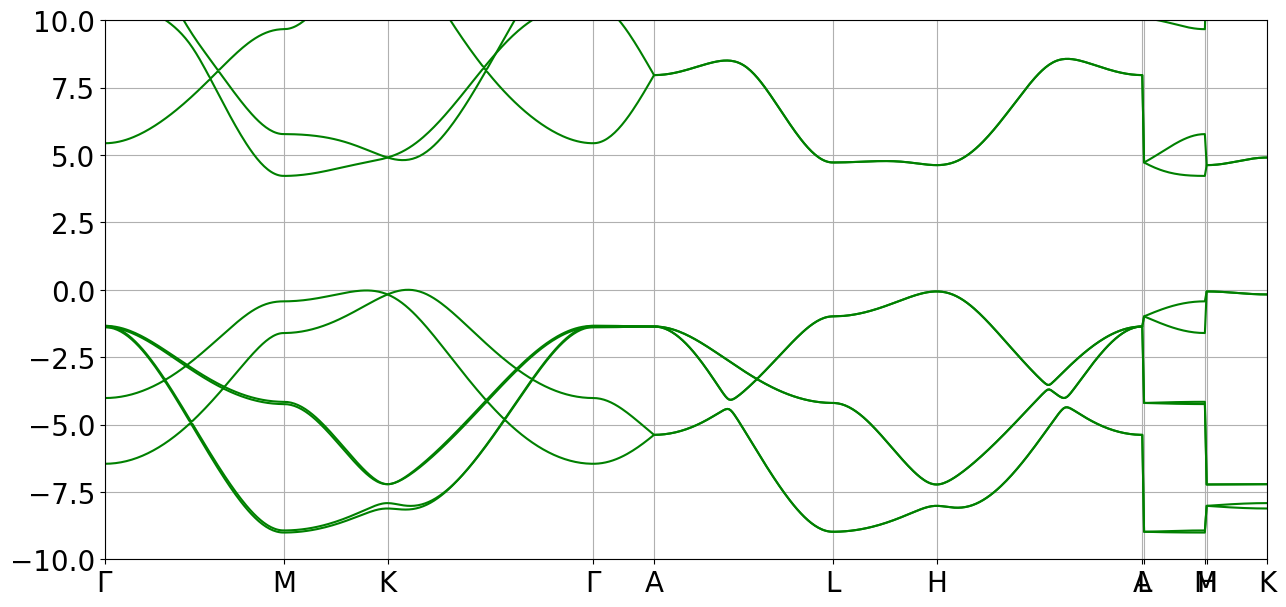

In [50]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(bands_qe.get_bands()-max(bands_qe.get_bands()[:,b-1]),'-',color='green',label = 'DFT')
plt.ylim(-10,10)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
#plt.ylim(-2,5)
#plt.legend()

#plt.savefig('plot_.pdf')

## Comparison with W90@QE

As you can see in the plot below, the interpolated band in the conduction region seems not to be in very good agreement with the quantum espresso one: this is due to the poor parameters that we used for this simulation.

In [51]:
dftw90 = w90_wkchain # orm.load_node(16085)
w90_qe = dftw90.outputs.band_structure

(0.0, 650.0)

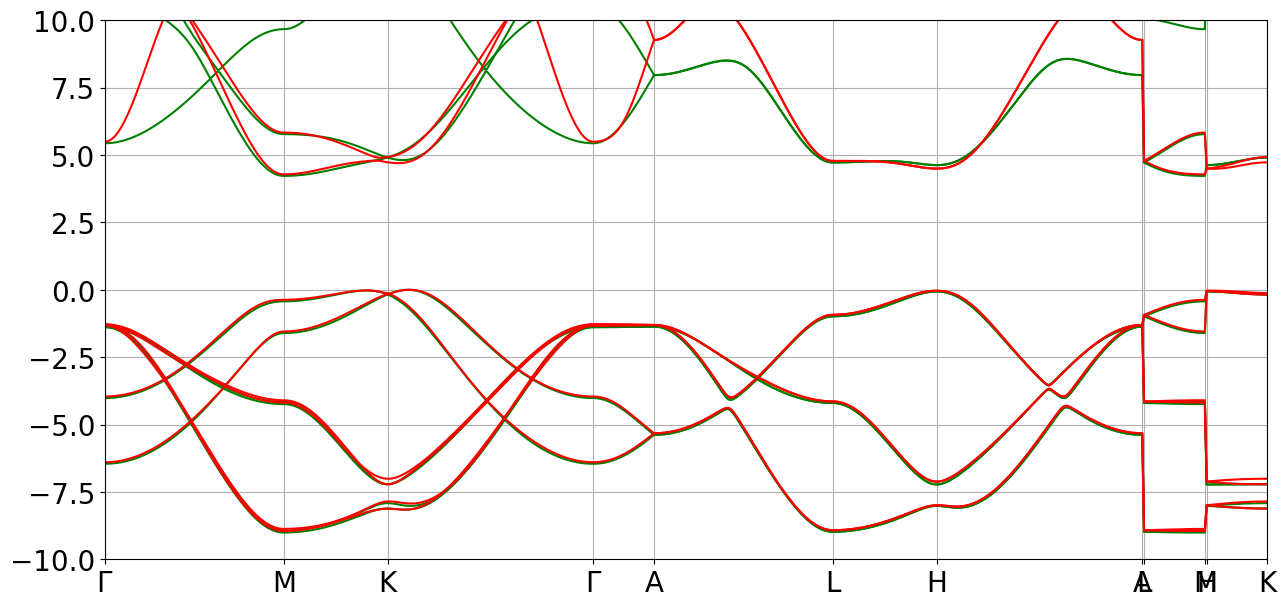

In [52]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(bands_qe.get_bands()-max(bands_qe.get_bands()[:,b-1]),'-',color='green',label = 'DFT')
plt.plot(w90_qe.get_bands()-max(w90_qe.get_bands()[:,b-1]),'-',color='red',label = 'W90')
plt.ylim(-10,10)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
#plt.ylim(-2,5)
#plt.legend()

#plt.savefig('plot_.pdf')